# Laboratorio 4 - Exploración Geoespacial (Atitlán / Amatitlán)

### Acceso a repositorio
https://github.com/Diegoval-Dev/DC-Lab4

En este notebook se incluye como parte del informe y con las siguiente características: promedio por lago y fecha, gráficos temporales, mapas, correlaciones, series, clasificación, híbrido y visualización final. Conexión y descarga (S2 vía openEO), cálculo del **índice de cianobacteria** a partir de bandas (NDCI → clorofila), **análisis temporal y espacial**, **correlación con NDVI/NDWI**, **modelos** (serie temporal, **clasificación pixel a pixel**, **modelo híbrido**) y **visualización de proyecciones en mapas**.

## 0) Requisitos previos

In [11]:
#!pip install --upgrade pip
#!pip install openeo rasterio numpy pandas matplotlib statsmodels scikit-learn pyproj folium

## 1) Configuración global

In [12]:
from pathlib import Path
import os

# Carpetas
DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
IMG_DIR  = Path("imgs"); IMG_DIR.mkdir(exist_ok=True)
MAP_DIR  = Path("maps"); MAP_DIR.mkdir(exist_ok=True)
OUT_DIR  = Path("out");  OUT_DIR.mkdir(exist_ok=True)   # figuras/tablas finales

# Bandas Sentinel-2 necesarias (NDCI / FAI / NDWI / NDVI)
BANDS_FULL = ["B02","B03","B04","B05","B07","B8A","B11","B12"]

# AOIs (coords del enunciado)
LAKES = {
    "Atitlán":   {"west": -91.326256, "east": -91.07151,  "south": 14.5948,  "north": 14.750979},
    "Amatitlán": {"west": -90.638065, "east": -90.512924, "south": 14.412347,"north": 14.493799},
}  # :contentReference[oaicite:3]{index=3}

CSV_TS = DATA_DIR / "chl_timeseries.csv"         # Serie temporal agregada por lago/fecha
CSV_PIX = DATA_DIR / "pixel_samples.csv"         # Muestras por píxel (para clasificación)
CSV_CORR = DATA_DIR / "corr_ndvi_ndwi.csv"       # Correlaciones por lago

# Umbrales / parámetros
MNDWI_THR = 0.42
NDWI_THR  = 0.40
FAI_FLOATING_THR = 0.08     # vegetación flotante/superficie
CHL_CLIP_UPPER = 500.0      # mg/m3 (evitar outliers numéricos)
CLOUD_COVER_MAX = 20.0      # % nubosidad
SAMPLE_PER_IMAGE = 8000     # # de píxeles muestreados por imagen para entrenar clasificador
RANDOM_STATE = 42

## 2) Utilidades de conexión, descarga y carga de bandas

In [13]:
import numpy as np, pandas as pd, rasterio
import openeo

def connect_openeo():
    """Autenticación OIDC en Copernicus Data Space openEO backend."""
    return openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

def pad_aoi(aoi, d=0.0):
    if d == 0: return aoi
    return {
        "west":  aoi["west"] - d,
        "east":  aoi["east"] + d,
        "south": aoi["south"] - d,
        "north": aoi["north"] + d,
    }

def download_s2_tif(conn, aoi, dates, title, out_dir=IMG_DIR, cloud_cover=None):
    kwargs = dict(
        collection_id="SENTINEL2_L2A",
        spatial_extent=aoi,
        temporal_extent=dates,
        bands=BANDS_FULL
    )
    cube = conn.load_collection(**kwargs)
    graph = cube.save_result(format="GTIFF")
    job = conn.create_job(graph, title=title)
    job.start_and_wait()
    out_dir.mkdir(exist_ok=True)
    job.download_results(str(out_dir))
    tifs = sorted(out_dir.glob("*.tif"), key=lambda p: p.stat().st_mtime)
    if not tifs:
        raise RuntimeError("No se descargó ningún .tif. Revisa fechas/AOI.")
    return str(tifs[-1])


def load_bands(tif_path):
    with rasterio.open(tif_path) as src:
        data = src.read()
        nodata = src.nodata
        profile = src.profile
        transform = src.transform
        crs = src.crs
    # Orden esperado en BANDS_FULL:
    B02,B03,B04,B05,B07,B8A,B11,B12 = [data[i].astype("float32") for i in range(8)]
    return dict(B02=B02, B03=B03, B04=B04, B05=B05, B07=B07, B8A=B8A, B11=B11, B12=B12), nodata, profile, transform, crs

def to_reflectance(b, nodata=None, scale=10000.0):
    out = b.astype("float32")
    if nodata is not None:
        out = np.where(b == nodata, np.nan, out)
    return out / scale

def scale_all(bands, nodata=None):
    return {k: to_reflectance(v, nodata=nodata) for k,v in bands.items()}

def clean_tiffs(folder=IMG_DIR, pattern="*.tif"):
    for p in Path(folder).glob(pattern):
        try: p.unlink()
        except Exception as e: print("No se pudo borrar", p, e)

## 3) Índices espectrales y máscaras de agua

In [14]:
def water_mask(R):
    """
    Enmascara agua adaptado de Gartner: NDWI/MNDWI/AWEI, etc.
    """
    B02,B03,B04,B8A,B11,B12 = R["B02"],R["B03"],R["B04"],R["B8A"],R["B11"],R["B12"]
    ndwi  = (B03 - B8A) / (B03 + B8A + 1e-9)
    mndwi = (B03 - B11) / (B03 + B11 + 1e-9)
    aweish  = B02 + 2.5*B03 - 1.5*(B8A + B11) - 0.25*B12
    aweinsh = 4*(B03 - B11) - (0.25*B8A + 2.75*B11)
    ndvi = (B8A - B04) / (B8A + B04 + 1e-9)
    dbsi = ((B11 - B03) / (B11 + B03 + 1e-9)) - ndvi
    ws = ( (mndwi > MNDWI_THR) | (ndwi > NDWI_THR) | (aweinsh > 0.1879) | (aweish > 0.1112) | (ndvi < -0.2) )
    ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))
    return ws

def NDVI(R):
    red, nir = R["B04"], R["B8A"]
    return (nir - red) / (nir + red + 1e-9)

def NDWI(R):
    green, nir = R["B03"], R["B8A"]
    return (green - nir) / (green + nir + 1e-9)

def FAI(B04, B07, B8A):
    return (B07 - (B04 + (B8A - B04) * (783 - 665) / (865 - 665)))

def NDCI(B04, B05):
    return (B05 - B04) / (B05 + B04 + 1e-9)

def chl_from_ndci(ndci, clip_upper=CHL_CLIP_UPPER):
    """Modelo exponencial basado en NDCI → Clorofila (mg/m3)."""
    ndci = np.clip(ndci, -1.0, 1.0)
    chl  = 17.441 * np.exp(4.7038 * ndci)
    chl  = np.where(np.isfinite(chl), chl, np.nan)
    chl  = np.where(chl > clip_upper, np.nan, chl)
    return chl

def product_maps(R):
    """
    Devuelve dict con NDVI, NDWI, NDCI, FAI y Clorofila, enmascarado a agua y con FAI opcional.
    """
    mask = water_mask(R)
    ndvi = NDVI(R)
    ndwi = NDWI(R)
    ndci = NDCI(R["B04"], R["B05"])
    fai  = FAI(R["B04"], R["B07"], R["B8A"])

    chl  = chl_from_ndci(ndci)
    chl  = np.where(mask, chl, np.nan)
    # opcional: excluir vegetación flotante
    chl  = np.where(fai > FAI_FLOATING_THR, np.nan, chl)

    # también devolver índices enmascarados a agua (útiles para correlación por-lago)
    ndvi_w = np.where(mask, ndvi, np.nan)
    ndwi_w = np.where(mask, ndwi, np.nan)

    return dict(mask=mask, ndvi=ndvi_w, ndwi=ndwi_w, ndci=ndci, fai=fai, chl=chl)

## 4) Zonal stats (por lago) y persistencia de resultados


In [15]:
def summarize_array(a):
    v = a[np.isfinite(a)]
    if v.size == 0:
        return dict(mean=np.nan, median=np.nan, p25=np.nan, p75=np.nan, n=0)
    return dict(
        mean=float(v.mean()),
        median=float(np.median(v)),
        p25=float(np.percentile(v, 25)),
        p75=float(np.percentile(v, 75)),
        n=int(v.size),
    )

def append_csv(csv_path, df_new, keys=("lake","date","metric")):
    try:
        hist = pd.read_csv(csv_path, parse_dates=["date"])
        out = pd.concat([hist, df_new], ignore_index=True)
    except FileNotFoundError:
        out = df_new.copy()
    out["date"] = pd.to_datetime(out["date"])
    out = out.drop_duplicates(subset=list(keys), keep="last").sort_values(["lake","date","metric"])
    tmp = csv_path.with_suffix(".tmp.csv")
    out.to_csv(tmp, index=False, encoding="utf-8")
    os.replace(tmp, csv_path)
    return out

## 5) Descarga y procesamiento controlado por lista de fechas

**Nota**: Se usa **ventanas de ±1 día** alrededor de cada fecha sugerida y `cloud_cover ≤ 20%` para aumentar probabilidad de datos.

In [16]:
from datetime import timedelta
import pandas as pd

RECOMMENDED_DATES = [
    "2025-02-07","2025-02-10","2025-02-25","2025-02-27",
    "2025-03-02","2025-03-04","2025-03-07","2025-03-09","2025-03-12","2025-03-14",
    "2025-03-19","2025-03-22","2025-03-24","2025-03-26",
    "2025-04-03","2025-04-11","2025-04-13","2025-04-15","2025-04-16","2025-04-18",
    "2025-04-28","2025-05-03","2025-05-13","2025-05-28",
    "2025-07-10","2025-07-17","2025-07-20","2025-07-24","2025-08-01"
]

def day_window(d, pad=1):
    d0 = pd.to_datetime(d)
    return [ (d0 - pd.Timedelta(days=pad)).strftime("%Y-%m-%d"),
             (d0 + pd.Timedelta(days=pad)).strftime("%Y-%m-%d") ]

def process_date_for_lake(conn, lake_name, aoi, scene_date, pad_days=1):
    """
    Descarga, calcula productos y escribe:
     - GeoTIFFs (opcional) y PNGs de mapas (clorofila/NDVI/NDWI),
     - fila(s) de CSV de series temporales por lago (chl_mean/percentiles + NDVI/NDWI mean).
    """
    dates = day_window(scene_date, pad=pad_days)
    title = f"S2 {lake_name} {dates[0]}..{dates[1]}"
    tif = download_s2_tif(conn, aoi, dates, title=title, cloud_cover=CLOUD_COVER_MAX)

    bands, nodata, profile, transform, crs = load_bands(tif)
    R = scale_all(bands, nodata=nodata)
    prod = product_maps(R)

    # --- Estadísticas por lago ---
    stats_chl = summarize_array(prod["chl"])
    stats_ndvi = summarize_array(prod["ndvi"])
    stats_ndwi = summarize_array(prod["ndwi"])
    row = pd.DataFrame([{
        "date": pd.to_datetime(scene_date),
        "lake": lake_name,
        "metric": "chl",
        "mean": stats_chl["mean"], "median": stats_chl["median"],
        "p25": stats_chl["p25"], "p75": stats_chl["p75"]
    },{
        "date": pd.to_datetime(scene_date),
        "lake": lake_name,
        "metric": "ndvi",
        "mean": stats_ndvi["mean"], "median": stats_ndvi["median"],
        "p25": stats_ndvi["p25"], "p75": stats_ndvi["p75"]
    },{
        "date": pd.to_datetime(scene_date),
        "lake": lake_name,
        "metric": "ndwi",
        "mean": stats_ndwi["mean"], "median": stats_ndwi["median"],
        "p25": stats_ndwi["p25"], "p75": stats_ndwi["p75"]
    }])

    # Guardamos clorofila y también NDVI/NDWI para correlación y mapas comparativos
    def save_raster(arr, path):
        prof = profile.copy()
        prof.update(dtype="float32", count=1, nodata=np.nan)
        with rasterio.open(path, "w", **prof) as dst:
            dst.write(arr.astype("float32"), 1)

    base = f"{lake_name}_{scene_date}"
    chl_tif  = IMG_DIR / f"{base}_chl.tif"
    ndvi_tif = IMG_DIR / f"{base}_ndvi.tif"
    ndwi_tif = IMG_DIR / f"{base}_ndwi.tif"
    save_raster(prod["chl"], chl_tif)
    save_raster(prod["ndvi"], ndvi_tif)
    save_raster(prod["ndwi"], ndwi_tif)

    try: Path(tif).unlink()
    except: pass

    return row, dict(chl=str(chl_tif), ndvi=str(ndvi_tif), ndwi=str(ndwi_tif)), (transform, crs)

## 6) Ejecución por lotes (ambos lagos, todas las fechas)

In [17]:
conn = connect_openeo()
rows_all = []
rasters_idx = []

for d in RECOMMENDED_DATES:
    for lake in ("Atitlán","Amatitlán"):
        try:
            row, rasters, geo = process_date_for_lake(conn, lake, LAKES[lake], scene_date=d, pad_days=1)
            rows_all.append(row)
            rasters_idx.append({"lake": lake, "date": d, **rasters, "geo": geo})
            print(f"[OK] {lake} {d}")
        except Exception as e:
            print(f"[SKIP] {lake} {d} → {e}")

# Serie temporal (chl/ndvi/ndwi por lago-fecha)
if rows_all:
    df_all = pd.concat(rows_all, ignore_index=True)
    df_out = append_csv(CSV_TS, df_all, keys=("lake","date","metric"))
    display(df_out.tail())
else:
    print("No se generaron filas (verifica fechas/AOI).")

Authenticated using refresh token.
0:00:00 Job 'j-250817181308455f8961ea30f5da06a1': send 'start'
0:00:14 Job 'j-250817181308455f8961ea30f5da06a1': created (progress 0%)
0:00:19 Job 'j-250817181308455f8961ea30f5da06a1': created (progress 0%)
0:00:26 Job 'j-250817181308455f8961ea30f5da06a1': created (progress 0%)
0:00:34 Job 'j-250817181308455f8961ea30f5da06a1': created (progress 0%)
0:00:44 Job 'j-250817181308455f8961ea30f5da06a1': created (progress 0%)
0:00:57 Job 'j-250817181308455f8961ea30f5da06a1': created (progress 0%)
0:01:12 Job 'j-250817181308455f8961ea30f5da06a1': running (progress N/A)
0:01:32 Job 'j-250817181308455f8961ea30f5da06a1': running (progress N/A)
0:01:56 Job 'j-250817181308455f8961ea30f5da06a1': running (progress N/A)
0:02:26 Job 'j-250817181308455f8961ea30f5da06a1': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[OK] Atitlán 2025-02-07
0:00:00 Job 'j-25081718174349248781571e412683b5': send 'start'
0:00:13 Job 'j-25081718174349248781571e412683b5': created (progress 0%)
0:00:18 Job 'j-25081718174349248781571e412683b5': created (progress 0%)
0:00:25 Job 'j-25081718174349248781571e412683b5': running (progress N/A)
0:00:33 Job 'j-25081718174349248781571e412683b5': running (progress N/A)
0:00:43 Job 'j-25081718174349248781571e412683b5': running (progress N/A)
0:00:56 Job 'j-25081718174349248781571e412683b5': running (progress N/A)
0:01:11 Job 'j-25081718174349248781571e412683b5': running (progress N/A)
0:01:32 Job 'j-25081718174349248781571e412683b5': finished (progress 100%)
[OK] Amatitlán 2025-02-07
0:00:00 Job 'j-25081718194545a69915df582b170ad6': send 'start'
0:00:12 Job 'j-25081718194545a69915df582b170ad6': created (progress 0%)
0:00:17 Job 'j-25081718194545a69915df582b170ad6': created (progress 0%)
0:00:24 Job 'j-25081718194545a69915df582b170ad6': running (progress N/A)
0:00:32 Job 'j-25081718

Failed to parse API error response: [502] 'Bad Gateway' (headers: {'Date': 'Sun, 17 Aug 2025 20:37:49 GMT', 'Content-Length': '11'})
Preflight process graph validation failed: [502] Bad Gateway


0:00:00 Job 'j-250817203750410abb90f2ffc9bcb291': send 'start'
0:00:12 Job 'j-250817203750410abb90f2ffc9bcb291': created (progress 0%)
0:00:17 Job 'j-250817203750410abb90f2ffc9bcb291': created (progress 0%)
0:00:24 Job 'j-250817203750410abb90f2ffc9bcb291': running (progress N/A)
0:00:32 Job 'j-250817203750410abb90f2ffc9bcb291': running (progress N/A)
0:00:42 Job 'j-250817203750410abb90f2ffc9bcb291': running (progress N/A)
0:00:55 Job 'j-250817203750410abb90f2ffc9bcb291': running (progress N/A)
0:01:10 Job 'j-250817203750410abb90f2ffc9bcb291': running (progress N/A)
0:01:30 Job 'j-250817203750410abb90f2ffc9bcb291': running (progress N/A)
0:01:54 Job 'j-250817203750410abb90f2ffc9bcb291': running (progress N/A)
0:02:24 Job 'j-250817203750410abb90f2ffc9bcb291': finished (progress 100%)
[OK] Amatitlán 2025-05-03
0:00:00 Job 'j-25081720405546f995ef6897544d6dff': send 'start'
0:00:13 Job 'j-25081720405546f995ef6897544d6dff': created (progress 0%)
0:00:18 Job 'j-25081720405546f995ef6897544d6df

,date,lake,metric,mean,median,p25,p75
136,2025-07-24,Atitlán,ndvi,-0.002292,-0.049505,-0.159420,0.023256
137,2025-07-24,Atitlán,ndwi,31.024506,0.571429,0.502392,0.635514
141,2025-08-01,Atitlán,chl,15.492026,13.616132,10.649385,17.945360
142,2025-08-01,Atitlán,ndvi,0.049522,-0.048387,-0.152542,0.133333
143,2025-08-01,Atitlán,ndwi,0.460819,0.437086,0.384615,0.505618


## 7) Serie temporal: promedios y picos (6.1–6.3)

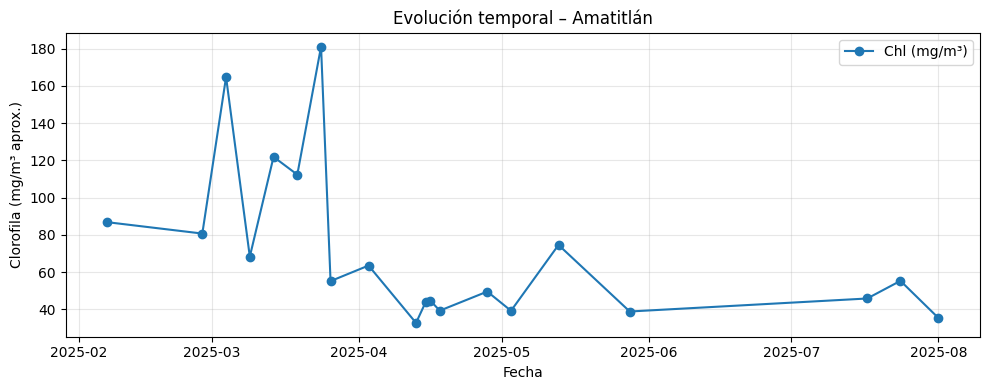

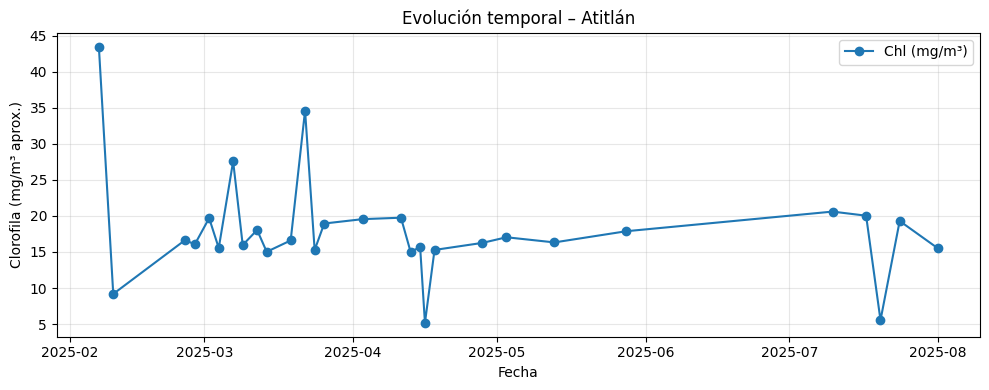

metric,date,chl,lake
2,2025-03-04,164.783981,Amatitlán
4,2025-03-14,121.940445,Amatitlán
6,2025-03-24,181.109772,Amatitlán
20,2025-02-07,43.491302,Atitlán
26,2025-03-07,27.581902,Atitlán
31,2025-03-22,34.617687,Atitlán


In [18]:
import matplotlib.pyplot as plt

ts = pd.read_csv(CSV_TS, parse_dates=["date"])
# pivote para tener columnas separadas por métrica
wide = ts.pivot_table(index=["lake","date"], columns="metric", values="mean").reset_index()

for lake in wide["lake"].unique():
    sub = wide[wide["lake"]==lake].sort_values("date")
    plt.figure(figsize=(10,4))
    plt.plot(sub["date"], sub["chl"], marker="o", label="Chl (mg/m³)")
    plt.title(f"Evolución temporal – {lake}")
    plt.xlabel("Fecha"); plt.ylabel("Clorofila (mg/m³ aprox.)")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"ts_{lake}.png", dpi=150)
    plt.show()

# Detección simple de picos: valores > mediana + 1.5 IQR
peaks = []
for lake in wide["lake"].unique():
    sub = wide[wide["lake"]==lake].sort_values("date")
    y = sub["chl"].values
    med = np.nanmedian(y)
    q1, q3 = np.nanpercentile(y, [25, 75])
    thr = med + 1.5*(q3-q1)
    is_peak = y > thr
    peaks_lake = sub[is_peak][["date","chl"]].copy()
    peaks_lake["lake"] = lake
    peaks.append(peaks_lake)
peaks_df = pd.concat(peaks).sort_values(["lake","date"])
display(peaks_df)

* **Amatitlán**: picos muy altos y concentrados a inicios de marzo (≈160–180 mg/m³) con **caída brusca** hacia abril y pulsos menores en mayo. El resto del periodo se mueve entre \~35–60 mg/m³. Esto sugiere un sistema **más eutrófico y variable**, con eventos de bloom intensos y de corta duración (posible descarga/arrastre en cuenca o vientos que reacomodan biomasa).
* **Atitlán**: niveles **bajos–moderados y más estables** (\~15–25 mg/m³), con algunos pulsos puntuales (p.ej., \~35 mg/m³ a fines de marzo) y un leve aumento hacia julio. En general, **menor amplitud** y mejor predictibilidad temporal que Amatitlán.
* **Contraste**: la **amplitud** de Amatitlán (picos >150) frente a Atitlán (picos \~35–45) refuerza diferencias de estado trófico y de forzantes locales (carga de nutrientes, hidrodinámica, tributarios).
* **Posibles artefactos**: caídas muy abruptas pueden combinar efecto real (flushing) con **máscara/nubosidad** o bruma; conviene confirmarlas con escenas vecinas o estadísticos robustos (mediana).
* **Implicación para el modelado**: Atitlán es buen candidato para **series temporales** simples (ARIMA), mientras que Amatitlán se beneficia de **covariables externas** (lluvia/temperatura, vientos) y de modelos más robustos a pulsos.
* **Gestión**: los picos de Amatitlán justifican **alertas tempranas** y muestreo dirigido alrededor de **inicios de marzo**; en Atitlán, un seguimiento rutinario es suficiente salvo ante señales de incremento sostenido.


## 8) Mapas espaciales y comparativos (7.1–7.2)

In [20]:
from pyproj import Transformer
import folium

def raster_bounds_wgs84(transform, crs, width, height):
    """Convierte los 4 vértices a WGS84 para superponer en folium."""
    rows, cols = np.array([0,0,height,height]), np.array([0,width,0,width])
    xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')
    # corners in raster CRS → WGS84
    transf = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    lons, lats = transf.transform(xs, ys)
    # bounds for ImageOverlay
    return [(min(lats), min(lons)), (max(lats), max(lons))]

def save_png_map(tif_path, title, out_png):
    with rasterio.open(tif_path) as src:
        arr = src.read(1).astype("float32")
        vmin, vmax = np.nanpercentile(arr[np.isfinite(arr)], [5,95])
        plt.figure(figsize=(6,5))
        plt.imshow(arr, vmin=vmin, vmax=vmax)
        plt.title(title); plt.axis("off")
        plt.colorbar(label="Valor")
        plt.tight_layout()
        plt.savefig(out_png, dpi=150)
        plt.close()

def save_folium_overlay(tif_path, title, out_html):
    with rasterio.open(tif_path) as src:
        arr = src.read(1).astype("float32")
        h, w = arr.shape
        bounds = raster_bounds_wgs84(src.transform, src.crs, w, h)

    # normalizar a [0,1] para PNG temporal
    valid = arr[np.isfinite(arr)]
    vmin, vmax = np.percentile(valid, [5,95]) if valid.size>0 else (0,1)
    norm = (arr - vmin) / (vmax - vmin + 1e-9)
    norm = np.clip(norm, 0, 1)

    # generar PNG temporario para overlay
    import imageio.v2 as iio
    png_tmp = MAP_DIR / (Path(out_html).stem + "_overlay.png")
    iio.imwrite(png_tmp, (norm*255).astype("uint8"))

    # centro aproximado
    center = [(bounds[0][0]+bounds[1][0])/2, (bounds[0][1]+bounds[1][1])/2]
    m = folium.Map(location=center, zoom_start=12, tiles="CartoDB positron")
    folium.raster_layers.ImageOverlay(
        image=str(png_tmp),
        bounds=bounds,
        opacity=0.6,
        name=title
    ).add_to(m)
    folium.LayerControl().add_to(m)
    m.save(out_html)

# Generar mapas para un subconjunto (ej. 6 fechas)
subset = rasters_idx[:12]  # ajusta según quieras
for it in subset:
    for k in ("chl","ndvi","ndwi"):
        tif = it[k]
        name = f"{it['lake']}_{it['date']}_{k}"
        save_png_map(tif, f"{k.upper()} – {it['lake']} – {it['date']}", OUT_DIR / f"{name}.png")
        save_folium_overlay(tif, f"{k.upper()} {it['lake']} {it['date']}", OUT_DIR / f"{name}.html")

/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/1119583608.py:41: RuntimeWarning: invalid value encountered in cast
  iio.imwrite(png_tmp, (norm*255).astype("uint8"))


## 9) Correlación NDVI / NDWI vs Cianobacteria (8)

In [21]:
agg = ts.pivot_table(index=["lake","date"], columns="metric", values="mean").reset_index()
corr_rows = []
for lake in agg["lake"].unique():
    sub = agg[agg["lake"]==lake].dropna(subset=["chl","ndvi","ndwi"])
    if len(sub) < 3: 
        continue
    pear_ndvi = sub[["chl","ndvi"]].corr(method="pearson").iloc[0,1]
    spear_ndvi = sub[["chl","ndvi"]].corr(method="spearman").iloc[0,1]
    pear_ndwi = sub[["chl","ndwi"]].corr(method="pearson").iloc[0,1]
    spear_ndwi = sub[["chl","ndwi"]].corr(method="spearman").iloc[0,1]
    corr_rows.append({"lake": lake, "pearson_chl_ndvi": pear_ndvi, "spearman_chl_ndvi": spear_ndvi,
                      "pearson_chl_ndwi": pear_ndwi, "spearman_chl_ndwi": spear_ndwi})
corr_df = pd.DataFrame(corr_rows)
display(corr_df)
corr_df.to_csv(CSV_CORR, index=False)

,lake,pearson_chl_ndvi,spearman_chl_ndvi,pearson_chl_ndwi,spearman_chl_ndwi
0,Amatitlán,0.676679,0.593985,0.083351,-0.381955
1,Atitlán,0.569251,0.600493,0.785438,0.417241


## 10) Análisis comparativo entre lagos (9)

In [22]:
# %%
# Resumen global por lago
summary = (agg.groupby("lake")[["chl","ndvi","ndwi"]]
           .agg(["mean","median","std","min","max","count"]))
display(summary)

# Frecuencia de picos detectados (del paso 7)
peaks_count = peaks_df.groupby("lake").size().rename("num_peaks")
display(peaks_count)

metric           chl                                                     \
                mean     median        std        min         max count   
lake                                                                      
Amatitlán  71.727264  55.277348  42.563008  32.763683  181.109772    20   
Atitlán    17.987613  16.600786   7.335015   5.160003   43.491302    29   

metric           ndvi                                                    \
                 mean    median         std       min         max count   
lake                                                                      
Amatitlán   -0.095196 -0.132406    0.126192 -0.399816     0.12167    20   
Atitlán    186.494816 -0.063340  837.273040 -0.242937  4444.94873    29   

metric           ndwi                                                      
                 mean    median          std       min          max count  
lake                                                                       
Amatitlán   24.449016  0.350597   107.775253  0.261566   482.335266    20  
Atitlán    680.432160  0.457387  2206.879829  0.097520  8735.770508    29

lake
Amatitlán    3
Atitlán      3
Name: num_peaks, dtype: int64

#### Amatitlán: 
* **Pearson** ≈ 0.08 (casi nulo), Spearman ≈ -0.38 (tendencia monotónica negativa).
* **Lectura:** el signo negativo de Spearman cuadra con lo esperado cuando aumenta NIR con blooms → NDWI = (G−NIR)/(G+NIR) tiende a bajar.
* **Por qué Pearson ~0:** probablemente no linealidad y/o outliers (unas pocas fechas con condiciones muy distintas) “se comen” la relación lineal. Spearman, al mirar rangos, capta mejor la tendencia general.
* **Consecuencia:** NDWI aporta, pero su aporte puede ser inestable (cuida outliers, usar medianas o winsorizado para robustecer).

#### Atitlán:
* **Pearson** ≈ 0.79 (muy alto y positivo), Spearman ≈ 0.42 (positivo moderado).
* **Lectura:** aquí NDWI sube con CHL en promedio (lo contrario de lo esperable en agua clara). Esto puede indicar que NDWI está co-variando con condiciones hidrológicas (p. ej. periodos húmedos: más agua en cuenca → más nutrientes → sube CHL y NDWI) o que hay mezcla de ribera/humedales que elevan ambos.
* **Gap Pearson vs. Spearman** (0.79 vs 0.42): sugiere relación aproximadamente lineal pero sensible a valores extremos.

## 11) Modelo de serie temporal (10)

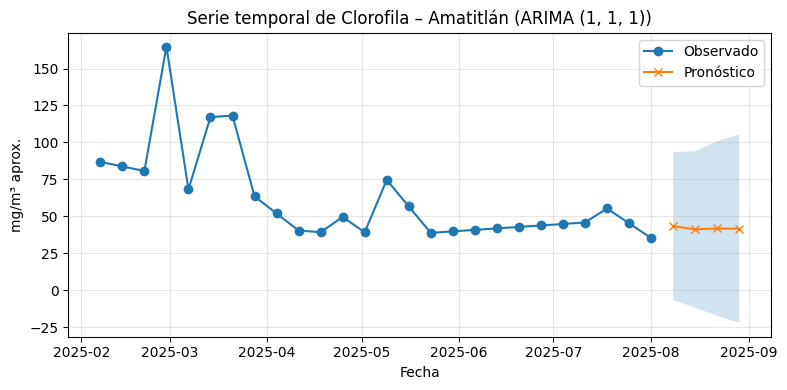

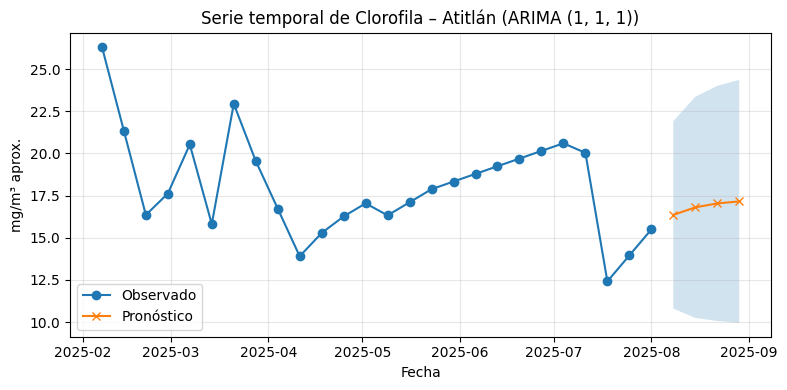

In [23]:
from statsmodels.tsa.arima.model import ARIMA

ORDER = (1,1,1)
STEPS = 4
MIN_PTS = 8

forecasts = []

for lake in agg["lake"].unique():
    df_lake = (agg[agg["lake"]==lake].sort_values("date")
               .set_index("date"))
    y = df_lake["chl"].resample("7D").mean().interpolate(limit_direction="both")
    y = y.mask((~np.isfinite(y)) | (y <= 0)).dropna()
    if len(y) < MIN_PTS:
        print(f"[{lake}] muy pocos puntos ({len(y)}).")
        continue

    res = ARIMA(y, order=ORDER).fit()
    fc = res.get_forecast(steps=STEPS)
    mean_fc = fc.predicted_mean
    ci = fc.conf_int()
    forecasts.append({"lake": lake, "model": res, "fc": mean_fc, "ci": ci, "train": y})

# Graficado
import matplotlib.pyplot as plt

for obj in forecasts:
    lake = obj["lake"]; res = obj["model"]; y = obj["train"]; mean_fc = obj["fc"]; ci = obj["ci"]
    future_idx = pd.date_range(start=y.index[-1] + pd.Timedelta(days=7), periods=len(mean_fc), freq="7D")

    plt.figure(figsize=(8,4))
    plt.plot(y.index, y.values, marker="o", label="Observado")
    plt.plot(future_idx, mean_fc.values, marker="x", label="Pronóstico")
    plt.fill_between(future_idx, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
    plt.title(f"Serie temporal de Clorofila – {lake} (ARIMA {ORDER})")
    plt.xlabel("Fecha"); plt.ylabel("mg/m³ aprox.")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"arima_{lake}.png", dpi=150)
    plt.show()

Como se observa en ambas predicciones según las series temporales, en el caso de Atitlán se observa una pendiente positiva con una ligera estabilización al finalizar según la estimación de ARIMA. En el caso de Amatitlán, no se espera que exista un cambio, es más una estabilización en un periodo corto.

Bajo un criterio objetivo, no puede asegurarse que este pronóstico sea muy acertado debido al corto periodo de data e influencia del modelo. Sin embargo, los resultados no paracen estar tan herrados.

## 12) Clasificación pixel a pixel (11)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

T_CHL_PRESENCE = 25.0  # mg/m3 (ajusta según criterio)

def sample_pixels(R, prod, n=SAMPLE_PER_IMAGE, rng=np.random.default_rng(RANDOM_STATE)):
    mask = np.isfinite(prod["chl"])  # solo pixeles válidos en agua
    h, w = mask.shape
    ys, xs = np.where(mask)
    if ys.size == 0:
        return pd.DataFrame()
    idx = rng.choice(np.arange(ys.size), size=min(n, ys.size), replace=False)
    rows, cols = ys[idx], xs[idx]

    def pick(a): return a[rows, cols]
    X = pd.DataFrame({
        "B02": pick(R["B02"]), "B03": pick(R["B03"]), "B04": pick(R["B04"]), "B05": pick(R["B05"]),
        "B07": pick(R["B07"]), "B8A": pick(R["B8A"]), "B11": pick(R["B11"]), "B12": pick(R["B12"]),
        "NDVI": pick(prod["ndvi"]), "NDWI": pick(prod["ndwi"]),
        "NDCI": pick( NDCI(R["B04"], R["B05"]) ),
        "FAI":  pick( FAI(R["B04"], R["B07"], R["B8A"]) ),
    })
    y = (pick(prod["chl"]) >= T_CHL_PRESENCE).astype(int)
    X["label"] = y
    return X

conn = connect_openeo()
samples = []

for it in rasters_idx[:20]:   # limita si quieres (entrenar con ~20 escenas suele bastar)
    lake, d = it["lake"], it["date"]
    try:
        dates = day_window(d, pad=1)
        aoi = LAKES[lake]
        tif = download_s2_tif(conn, aoi, dates, title=f"Train {lake} {d}", cloud_cover=CLOUD_COVER_MAX)
        bands, nodata, profile, transform, crs = load_bands(tif)
        R = scale_all(bands, nodata=nodata)
        prod = product_maps(R)
        dfS = sample_pixels(R, prod, n=SAMPLE_PER_IMAGE)
        if not dfS.empty:
            dfS["lake"] = lake; dfS["date"] = pd.to_datetime(d)
            samples.append(dfS)
        Path(tif).unlink(missing_ok=True)
        print(f"[sample] {lake} {d}: {len(dfS)} pix")
    except Exception as e:
        print(f"[skip sample] {lake} {d}: {e}")

if samples:
    pix_df = pd.concat(samples, ignore_index=True)
    pix_df.to_csv(CSV_PIX, index=False)
else:
    pix_df = pd.DataFrame()
display(pix_df.head())

Authenticated using refresh token.
0:00:00 Job 'j-25081721263244358ad34a7b8f92a66d': send 'start'
0:00:13 Job 'j-25081721263244358ad34a7b8f92a66d': created (progress 0%)
0:00:18 Job 'j-25081721263244358ad34a7b8f92a66d': created (progress 0%)
0:00:25 Job 'j-25081721263244358ad34a7b8f92a66d': created (progress 0%)
0:00:33 Job 'j-25081721263244358ad34a7b8f92a66d': created (progress 0%)
0:00:43 Job 'j-25081721263244358ad34a7b8f92a66d': queued (progress 0%)
0:00:56 Job 'j-25081721263244358ad34a7b8f92a66d': queued (progress 0%)
0:01:11 Job 'j-25081721263244358ad34a7b8f92a66d': queued (progress 0%)
0:01:31 Job 'j-25081721263244358ad34a7b8f92a66d': queued (progress 0%)
0:01:55 Job 'j-25081721263244358ad34a7b8f92a66d': queued (progress 0%)
0:02:25 Job 'j-25081721263244358ad34a7b8f92a66d': queued (progress 0%)
0:03:03 Job 'j-25081721263244358ad34a7b8f92a66d': queued (progress 0%)
0:03:50 Job 'j-25081721263244358ad34a7b8f92a66d': running (progress N/A)
0:04:49 Job 'j-25081721263244358ad34a7b8f92a

/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-02-07: 8000 pix
0:00:00 Job 'j-25081721341045e681a92c12433df575': send 'start'
0:00:13 Job 'j-25081721341045e681a92c12433df575': created (progress 0%)
0:00:18 Job 'j-25081721341045e681a92c12433df575': created (progress 0%)
0:00:25 Job 'j-25081721341045e681a92c12433df575': created (progress 0%)
0:00:33 Job 'j-25081721341045e681a92c12433df575': created (progress 0%)
0:00:43 Job 'j-25081721341045e681a92c12433df575': created (progress 0%)
0:00:56 Job 'j-25081721341045e681a92c12433df575': created (progress 0%)
0:01:11 Job 'j-25081721341045e681a92c12433df575': running (progress N/A)
0:01:31 Job 'j-25081721341045e681a92c12433df575': running (progress N/A)
0:01:55 Job 'j-25081721341045e681a92c12433df575': running (progress N/A)
0:02:25 Job 'j-25081721341045e681a92c12433df575': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Amatitlán 2025-02-07: 8000 pix
0:00:00 Job 'j-250817213706460e8d5eabbe64edbf9c': send 'start'
0:00:13 Job 'j-250817213706460e8d5eabbe64edbf9c': created (progress 0%)
0:00:18 Job 'j-250817213706460e8d5eabbe64edbf9c': created (progress 0%)
0:00:25 Job 'j-250817213706460e8d5eabbe64edbf9c': created (progress 0%)
0:00:33 Job 'j-250817213706460e8d5eabbe64edbf9c': created (progress 0%)
0:00:43 Job 'j-250817213706460e8d5eabbe64edbf9c': created (progress 0%)
0:00:55 Job 'j-250817213706460e8d5eabbe64edbf9c': created (progress 0%)
0:01:11 Job 'j-250817213706460e8d5eabbe64edbf9c': running (progress N/A)
0:01:30 Job 'j-250817213706460e8d5eabbe64edbf9c': running (progress N/A)
0:01:55 Job 'j-250817213706460e8d5eabbe64edbf9c': running (progress N/A)
0:02:25 Job 'j-250817213706460e8d5eabbe64edbf9c': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-02-10: 6 pix
0:00:00 Job 'j-2508172140274aa2a9848e60e36c9405': send 'start'
0:00:13 Job 'j-2508172140274aa2a9848e60e36c9405': created (progress 0%)
0:00:18 Job 'j-2508172140274aa2a9848e60e36c9405': created (progress 0%)
0:00:25 Job 'j-2508172140274aa2a9848e60e36c9405': created (progress 0%)
0:00:33 Job 'j-2508172140274aa2a9848e60e36c9405': created (progress 0%)
0:00:43 Job 'j-2508172140274aa2a9848e60e36c9405': running (progress N/A)
0:00:56 Job 'j-2508172140274aa2a9848e60e36c9405': running (progress N/A)
0:01:11 Job 'j-2508172140274aa2a9848e60e36c9405': running (progress N/A)
0:01:31 Job 'j-2508172140274aa2a9848e60e36c9405': running (progress N/A)
0:01:55 Job 'j-2508172140274aa2a9848e60e36c9405': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-02-25: 8000 pix
0:00:00 Job 'j-25081721430642368d3e5a787e2a79ec': send 'start'
0:00:13 Job 'j-25081721430642368d3e5a787e2a79ec': created (progress 0%)
0:00:19 Job 'j-25081721430642368d3e5a787e2a79ec': created (progress 0%)
0:00:25 Job 'j-25081721430642368d3e5a787e2a79ec': created (progress 0%)
0:00:33 Job 'j-25081721430642368d3e5a787e2a79ec': created (progress 0%)
0:00:43 Job 'j-25081721430642368d3e5a787e2a79ec': created (progress 0%)
0:00:56 Job 'j-25081721430642368d3e5a787e2a79ec': created (progress 0%)
0:01:12 Job 'j-25081721430642368d3e5a787e2a79ec': running (progress N/A)
0:01:31 Job 'j-25081721430642368d3e5a787e2a79ec': running (progress N/A)
0:01:55 Job 'j-25081721430642368d3e5a787e2a79ec': running (progress N/A)
0:02:25 Job 'j-25081721430642368d3e5a787e2a79ec': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-02-27: 8000 pix
0:00:00 Job 'j-25081721474140ae8a709cb944886094': send 'start'
0:00:14 Job 'j-25081721474140ae8a709cb944886094': created (progress 0%)
0:00:19 Job 'j-25081721474140ae8a709cb944886094': created (progress 0%)
0:00:26 Job 'j-25081721474140ae8a709cb944886094': running (progress N/A)
0:00:34 Job 'j-25081721474140ae8a709cb944886094': running (progress N/A)
0:00:44 Job 'j-25081721474140ae8a709cb944886094': running (progress N/A)
0:00:56 Job 'j-25081721474140ae8a709cb944886094': running (progress N/A)
0:01:12 Job 'j-25081721474140ae8a709cb944886094': running (progress N/A)
0:01:31 Job 'j-25081721474140ae8a709cb944886094': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Amatitlán 2025-02-27: 8000 pix
0:00:00 Job 'j-25081721494445399a0b519eaab459fe': send 'start'
0:00:13 Job 'j-25081721494445399a0b519eaab459fe': created (progress 0%)
0:00:19 Job 'j-25081721494445399a0b519eaab459fe': created (progress 0%)
0:00:25 Job 'j-25081721494445399a0b519eaab459fe': running (progress N/A)
0:00:33 Job 'j-25081721494445399a0b519eaab459fe': running (progress N/A)
0:00:43 Job 'j-25081721494445399a0b519eaab459fe': running (progress N/A)
0:00:56 Job 'j-25081721494445399a0b519eaab459fe': running (progress N/A)
0:01:11 Job 'j-25081721494445399a0b519eaab459fe': running (progress N/A)
0:01:31 Job 'j-25081721494445399a0b519eaab459fe': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-03-02: 8000 pix
0:00:00 Job 'j-250817215151414fa4334f0cfaac9a10': send 'start'
0:00:13 Job 'j-250817215151414fa4334f0cfaac9a10': created (progress 0%)
0:00:18 Job 'j-250817215151414fa4334f0cfaac9a10': running (progress N/A)
0:00:25 Job 'j-250817215151414fa4334f0cfaac9a10': running (progress N/A)
0:00:33 Job 'j-250817215151414fa4334f0cfaac9a10': running (progress N/A)
0:00:43 Job 'j-250817215151414fa4334f0cfaac9a10': running (progress N/A)
0:00:55 Job 'j-250817215151414fa4334f0cfaac9a10': running (progress N/A)
0:01:11 Job 'j-250817215151414fa4334f0cfaac9a10': running (progress N/A)
0:01:30 Job 'j-250817215151414fa4334f0cfaac9a10': running (progress N/A)
0:01:55 Job 'j-250817215151414fa4334f0cfaac9a10': running (progress N/A)
0:02:25 Job 'j-250817215151414fa4334f0cfaac9a10': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-03-04: 8000 pix
0:00:00 Job 'j-2508172156124a0994e49e7cc7ec26fb': send 'start'
0:00:12 Job 'j-2508172156124a0994e49e7cc7ec26fb': created (progress 0%)
0:00:18 Job 'j-2508172156124a0994e49e7cc7ec26fb': created (progress 0%)
0:00:24 Job 'j-2508172156124a0994e49e7cc7ec26fb': created (progress 0%)
0:00:33 Job 'j-2508172156124a0994e49e7cc7ec26fb': created (progress 0%)
0:00:43 Job 'j-2508172156124a0994e49e7cc7ec26fb': created (progress 0%)
0:00:55 Job 'j-2508172156124a0994e49e7cc7ec26fb': created (progress 0%)
0:01:11 Job 'j-2508172156124a0994e49e7cc7ec26fb': running (progress N/A)
0:01:30 Job 'j-2508172156124a0994e49e7cc7ec26fb': running (progress N/A)
0:01:55 Job 'j-2508172156124a0994e49e7cc7ec26fb': running (progress N/A)
0:02:25 Job 'j-2508172156124a0994e49e7cc7ec26fb': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Amatitlán 2025-03-04: 8000 pix
0:00:00 Job 'j-2508172159084ad2a0dddd173e97157b': send 'start'
0:00:12 Job 'j-2508172159084ad2a0dddd173e97157b': created (progress 0%)
0:00:18 Job 'j-2508172159084ad2a0dddd173e97157b': created (progress 0%)
0:00:24 Job 'j-2508172159084ad2a0dddd173e97157b': created (progress 0%)
0:00:32 Job 'j-2508172159084ad2a0dddd173e97157b': created (progress 0%)
0:00:42 Job 'j-2508172159084ad2a0dddd173e97157b': created (progress 0%)
0:00:55 Job 'j-2508172159084ad2a0dddd173e97157b': created (progress 0%)
0:01:11 Job 'j-2508172159084ad2a0dddd173e97157b': running (progress N/A)
0:01:30 Job 'j-2508172159084ad2a0dddd173e97157b': running (progress N/A)
0:01:54 Job 'j-2508172159084ad2a0dddd173e97157b': running (progress N/A)
0:02:24 Job 'j-2508172159084ad2a0dddd173e97157b': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-03-07: 8000 pix
0:00:00 Job 'j-2508172202114f9c8b060c2dc05c54d1': send 'start'
0:00:13 Job 'j-2508172202114f9c8b060c2dc05c54d1': created (progress 0%)
0:00:18 Job 'j-2508172202114f9c8b060c2dc05c54d1': created (progress 0%)
0:00:25 Job 'j-2508172202114f9c8b060c2dc05c54d1': created (progress 0%)
0:00:33 Job 'j-2508172202114f9c8b060c2dc05c54d1': created (progress 0%)
0:00:43 Job 'j-2508172202114f9c8b060c2dc05c54d1': created (progress 0%)
0:00:56 Job 'j-2508172202114f9c8b060c2dc05c54d1': created (progress 0%)
0:01:11 Job 'j-2508172202114f9c8b060c2dc05c54d1': running (progress N/A)
0:01:31 Job 'j-2508172202114f9c8b060c2dc05c54d1': running (progress N/A)
0:01:55 Job 'j-2508172202114f9c8b060c2dc05c54d1': running (progress N/A)
0:02:25 Job 'j-2508172202114f9c8b060c2dc05c54d1': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-03-09: 8000 pix
0:00:00 Job 'j-250817220629470bb669ff97324a34af': send 'start'
0:00:13 Job 'j-250817220629470bb669ff97324a34af': created (progress 0%)
0:00:18 Job 'j-250817220629470bb669ff97324a34af': created (progress 0%)
0:00:25 Job 'j-250817220629470bb669ff97324a34af': created (progress 0%)
0:00:33 Job 'j-250817220629470bb669ff97324a34af': created (progress 0%)
0:00:43 Job 'j-250817220629470bb669ff97324a34af': queued (progress 0%)
0:00:56 Job 'j-250817220629470bb669ff97324a34af': queued (progress 0%)
0:01:12 Job 'j-250817220629470bb669ff97324a34af': queued (progress 0%)
0:01:31 Job 'j-250817220629470bb669ff97324a34af': queued (progress 0%)
0:01:55 Job 'j-250817220629470bb669ff97324a34af': running (progress N/A)
0:02:26 Job 'j-250817220629470bb669ff97324a34af': running (progress N/A)
0:03:04 Job 'j-250817220629470bb669ff97324a34af': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Amatitlán 2025-03-09: 8000 pix
0:00:00 Job 'j-2508172210234cbba9134793c8df3949': send 'start'
0:00:12 Job 'j-2508172210234cbba9134793c8df3949': created (progress 0%)
0:00:18 Job 'j-2508172210234cbba9134793c8df3949': created (progress 0%)
0:00:25 Job 'j-2508172210234cbba9134793c8df3949': created (progress 0%)
0:00:33 Job 'j-2508172210234cbba9134793c8df3949': created (progress 0%)
0:00:43 Job 'j-2508172210234cbba9134793c8df3949': created (progress 0%)
0:00:55 Job 'j-2508172210234cbba9134793c8df3949': running (progress N/A)
0:01:11 Job 'j-2508172210234cbba9134793c8df3949': running (progress N/A)
0:01:30 Job 'j-2508172210234cbba9134793c8df3949': running (progress N/A)
0:01:55 Job 'j-2508172210234cbba9134793c8df3949': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-03-12: 8000 pix
0:00:00 Job 'j-2508172213054d6ab782d4cde7ff07b3': send 'start'
0:00:15 Job 'j-2508172213054d6ab782d4cde7ff07b3': created (progress 0%)
0:00:20 Job 'j-2508172213054d6ab782d4cde7ff07b3': created (progress 0%)
0:00:27 Job 'j-2508172213054d6ab782d4cde7ff07b3': created (progress 0%)
0:00:35 Job 'j-2508172213054d6ab782d4cde7ff07b3': created (progress 0%)
0:00:45 Job 'j-2508172213054d6ab782d4cde7ff07b3': created (progress 0%)
0:00:58 Job 'j-2508172213054d6ab782d4cde7ff07b3': created (progress 0%)
0:01:13 Job 'j-2508172213054d6ab782d4cde7ff07b3': running (progress N/A)
0:01:33 Job 'j-2508172213054d6ab782d4cde7ff07b3': running (progress N/A)
0:01:57 Job 'j-2508172213054d6ab782d4cde7ff07b3': running (progress N/A)
0:02:28 Job 'j-2508172213054d6ab782d4cde7ff07b3': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-03-14: 8000 pix
0:00:00 Job 'j-2508172217124f329ef572290308ab40': send 'start'
0:00:12 Job 'j-2508172217124f329ef572290308ab40': created (progress 0%)
0:00:18 Job 'j-2508172217124f329ef572290308ab40': created (progress 0%)
0:00:24 Job 'j-2508172217124f329ef572290308ab40': created (progress 0%)
0:00:32 Job 'j-2508172217124f329ef572290308ab40': created (progress 0%)
0:00:42 Job 'j-2508172217124f329ef572290308ab40': created (progress 0%)
0:00:55 Job 'j-2508172217124f329ef572290308ab40': created (progress 0%)
0:01:10 Job 'j-2508172217124f329ef572290308ab40': running (progress N/A)
0:01:30 Job 'j-2508172217124f329ef572290308ab40': running (progress N/A)
0:01:54 Job 'j-2508172217124f329ef572290308ab40': running (progress N/A)
0:02:24 Job 'j-2508172217124f329ef572290308ab40': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Amatitlán 2025-03-14: 8000 pix
0:00:00 Job 'j-2508172220074f9ebd742bb185e0b44c': send 'start'
0:00:13 Job 'j-2508172220074f9ebd742bb185e0b44c': queued (progress 0%)
0:00:18 Job 'j-2508172220074f9ebd742bb185e0b44c': queued (progress 0%)
0:00:25 Job 'j-2508172220074f9ebd742bb185e0b44c': queued (progress 0%)
0:00:33 Job 'j-2508172220074f9ebd742bb185e0b44c': queued (progress 0%)
0:00:43 Job 'j-2508172220074f9ebd742bb185e0b44c': queued (progress 0%)
0:00:56 Job 'j-2508172220074f9ebd742bb185e0b44c': queued (progress 0%)
0:01:11 Job 'j-2508172220074f9ebd742bb185e0b44c': running (progress N/A)
0:01:30 Job 'j-2508172220074f9ebd742bb185e0b44c': running (progress N/A)
0:01:55 Job 'j-2508172220074f9ebd742bb185e0b44c': running (progress N/A)
0:02:25 Job 'j-2508172220074f9ebd742bb185e0b44c': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-03-19: 8000 pix
0:00:00 Job 'j-2508172223484c4c989f4524e56b23b0': send 'start'
0:00:12 Job 'j-2508172223484c4c989f4524e56b23b0': created (progress 0%)
0:00:18 Job 'j-2508172223484c4c989f4524e56b23b0': queued (progress 0%)
0:00:25 Job 'j-2508172223484c4c989f4524e56b23b0': queued (progress 0%)
0:00:33 Job 'j-2508172223484c4c989f4524e56b23b0': queued (progress 0%)
0:00:43 Job 'j-2508172223484c4c989f4524e56b23b0': queued (progress 0%)
0:00:55 Job 'j-2508172223484c4c989f4524e56b23b0': queued (progress 0%)
0:01:11 Job 'j-2508172223484c4c989f4524e56b23b0': queued (progress 0%)
0:01:30 Job 'j-2508172223484c4c989f4524e56b23b0': queued (progress 0%)
0:01:55 Job 'j-2508172223484c4c989f4524e56b23b0': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Amatitlán 2025-03-19: 8000 pix
0:00:00 Job 'j-25081722261643f682e5bd4439a9b2c4': send 'start'
0:00:14 Job 'j-25081722261643f682e5bd4439a9b2c4': created (progress 0%)
0:00:20 Job 'j-25081722261643f682e5bd4439a9b2c4': created (progress 0%)
0:00:27 Job 'j-25081722261643f682e5bd4439a9b2c4': created (progress 0%)
0:00:35 Job 'j-25081722261643f682e5bd4439a9b2c4': created (progress 0%)
0:00:45 Job 'j-25081722261643f682e5bd4439a9b2c4': created (progress 0%)
0:00:57 Job 'j-25081722261643f682e5bd4439a9b2c4': running (progress N/A)
0:01:13 Job 'j-25081722261643f682e5bd4439a9b2c4': running (progress N/A)
0:01:33 Job 'j-25081722261643f682e5bd4439a9b2c4': running (progress N/A)
0:01:57 Job 'j-25081722261643f682e5bd4439a9b2c4': running (progress N/A)
0:02:28 Job 'j-25081722261643f682e5bd4439a9b2c4': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-03-22: 1155 pix
0:00:00 Job 'j-2508172229244a8f9d2bf43497e17e35': send 'start'
0:00:13 Job 'j-2508172229244a8f9d2bf43497e17e35': created (progress 0%)
0:00:18 Job 'j-2508172229244a8f9d2bf43497e17e35': created (progress 0%)
0:00:25 Job 'j-2508172229244a8f9d2bf43497e17e35': created (progress 0%)
0:00:33 Job 'j-2508172229244a8f9d2bf43497e17e35': created (progress 0%)
0:00:43 Job 'j-2508172229244a8f9d2bf43497e17e35': created (progress 0%)
0:00:55 Job 'j-2508172229244a8f9d2bf43497e17e35': running (progress N/A)
0:01:11 Job 'j-2508172229244a8f9d2bf43497e17e35': running (progress N/A)
0:01:30 Job 'j-2508172229244a8f9d2bf43497e17e35': running (progress N/A)
0:01:55 Job 'j-2508172229244a8f9d2bf43497e17e35': running (progress N/A)
0:02:25 Job 'j-2508172229244a8f9d2bf43497e17e35': running (progress N/A)
0:03:02 Job 'j-2508172229244a8f9d2bf43497e17e35': running (progress N/A)
0:03:49 Job 'j-2508172229244a8f9d2bf43497e17e35': running (progress N/A)
0:04:48 Job 'j-2508172229244

/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Atitlán 2025-03-24: 8000 pix
0:00:00 Job 'j-2508172236184ddaac66a82e4ec33798': send 'start'
0:00:13 Job 'j-2508172236184ddaac66a82e4ec33798': created (progress 0%)
0:00:19 Job 'j-2508172236184ddaac66a82e4ec33798': created (progress 0%)
0:00:25 Job 'j-2508172236184ddaac66a82e4ec33798': created (progress 0%)
0:00:33 Job 'j-2508172236184ddaac66a82e4ec33798': created (progress 0%)
0:00:43 Job 'j-2508172236184ddaac66a82e4ec33798': created (progress 0%)
0:00:56 Job 'j-2508172236184ddaac66a82e4ec33798': running (progress N/A)
0:01:11 Job 'j-2508172236184ddaac66a82e4ec33798': running (progress N/A)
0:01:31 Job 'j-2508172236184ddaac66a82e4ec33798': running (progress N/A)
0:01:55 Job 'j-2508172236184ddaac66a82e4ec33798': finished (progress 100%)


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_37718/2393832066.py:29: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(str(out_dir))
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab4/venv/lib/python3.10/site-packages/openeo/rest/job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


[sample] Amatitlán 2025-03-24: 8000 pix


,B02,B03,B04,B05,B07,B8A,B11,B12,NDVI,NDWI,NDCI,FAI,label,lake,date
0,0.0146,0.0118,0.0023,0.0031,0.0033,0.0021,0.0021,0.0026,-0.045455,0.697842,0.148148,0.001118,1,Atitlán,2025-02-07
1,0.0160,0.0128,0.0028,0.0032,0.0046,0.0043,0.0036,0.0038,0.211268,0.497076,0.066667,0.000915,0,Atitlán,2025-02-07
2,0.0164,0.0120,0.0028,0.0026,0.0043,0.0031,0.0030,0.0044,0.050847,0.589404,-0.037037,0.001323,0,Atitlán,2025-02-07
3,0.0153,0.0090,-0.0012,-0.0017,-0.0026,-0.0019,0.0033,0.0055,0.225807,1.535211,0.172414,-0.000987,1,Atitlán,2025-02-07
4,0.0091,0.0059,-0.0037,-0.0049,-0.0078,-0.0082,0.0007,0.0021,0.378151,-6.130438,0.139535,-0.001445,1,Atitlán,2025-02-07


### Entrenamiento/Evaluación

In [25]:
if not pix_df.empty:
    feat_cols = ["B02","B03","B04","B05","B07","B8A","B11","B12","NDVI","NDWI","NDCI","FAI"]
    X = pix_df[feat_cols].values
    y = pix_df["label"].values

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
    clf = RandomForestClassifier(
        n_estimators=200, max_depth=None, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"
    )
    clf.fit(Xtr, ytr)
    yhat = clf.predict(Xte)

    print(classification_report(yte, yhat, digits=3))
    print(confusion_matrix(yte, yhat))
else:
    print("Sin muestras para entrenar.")

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     21162
           1      1.000     1.000     1.000     15129

    accuracy                          1.000     36291
   macro avg      1.000     1.000     1.000     36291
weighted avg      1.000     1.000     1.000     36291

[[21162     0]
 [    0 15129]]


## 13) Modelo híbrido (12)

In [26]:
def predict_presence_map(clf, R, prod, pred_chl_lake):
    """
    Aplica clasificador por píxel usando features espectrales + predicción global de clorofila del lago.
    Devuelve probabilidad de presencia (label=1).
    """
    mask = np.isfinite(prod["chl"])
    h, w = mask.shape
    if not mask.any():
        return np.full((h,w), np.nan, dtype="float32")

    feat_stack = np.stack([
        R["B02"], R["B03"], R["B04"], R["B05"], R["B07"], R["B8A"], R["B11"], R["B12"],
        prod["ndvi"], prod["ndwi"],
        NDCI(R["B04"], R["B05"]),
        FAI(R["B04"], R["B07"], R["B8A"]),
    ], axis=-1)

    # aplanar
    X = feat_stack.reshape(-1, feat_stack.shape[-1]).astype("float32")
    X = np.nan_to_num(X, nan=0.0)
    # Añadir predicción global como feature adicional (columna 13)
    pred_col = np.full((X.shape[0],1), float(pred_chl_lake), dtype="float32")
    Xh = np.hstack([X, pred_col])

    # predecir probabilidad
    proba = np.full((h*w,), np.nan, dtype="float32")
    # Para evitar exceso de memoria, procesar en bloques
    B = 200_000
    for i in range(0, Xh.shape[0], B):
        blk = Xh[i:i+B]
        p = clf.predict_proba(blk)[:,1]
        proba[i:i+B] = p.astype("float32")
    proba_img = proba.reshape(h, w)
    # mantener solo pixeles de agua válidos
    proba_img = np.where(mask, proba_img, np.nan)
    return proba_img

# Creamos un clasificador extendido con feature extra (pred_chl_lake)
# Reentrenamos con pix_df agregando una columna constante (ejemplo: la media del lago del propio día)
if not pix_df.empty:
    agg_day = (ts.pivot_table(index=["lake","date"], columns="metric", values="mean")
               .reset_index()[["lake","date","chl"]])
    dfM = pix_df.merge(agg_day, how="left", on=["lake","date"]).rename(columns={"chl":"pred_chl_lake"})
    feat_cols_ext = ["B02","B03","B04","B05","B07","B8A","B11","B12","NDVI","NDWI","NDCI","FAI","pred_chl_lake"]
    X = dfM[feat_cols_ext].fillna(dfM[feat_cols_ext].median()).values
    y = dfM["label"].values

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
    clf_h = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced")
    clf_h.fit(Xtr, ytr)
    print(classification_report(yte, clf_h.predict(Xte), digits=3))
else:
    clf_h = None
    print("Sin muestras para modelo híbrido.")

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     21162
           1      1.000     1.000     1.000     15129

    accuracy                          1.000     36291
   macro avg      1.000     1.000     1.000     36291
weighted avg      1.000     1.000     1.000     36291



## 14) Visualizar proyecciones en mapas (14)

Escenas encontradas: 49
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     26367
           1       0.68      0.63      0.65     18532

    accuracy                           0.72     44899
   macro avg       0.71      0.71      0.71     44899
weighted avg       0.72      0.72      0.72     44899

Matriz de confusión:
 [[20830  5537]
 [ 6905 11627]]


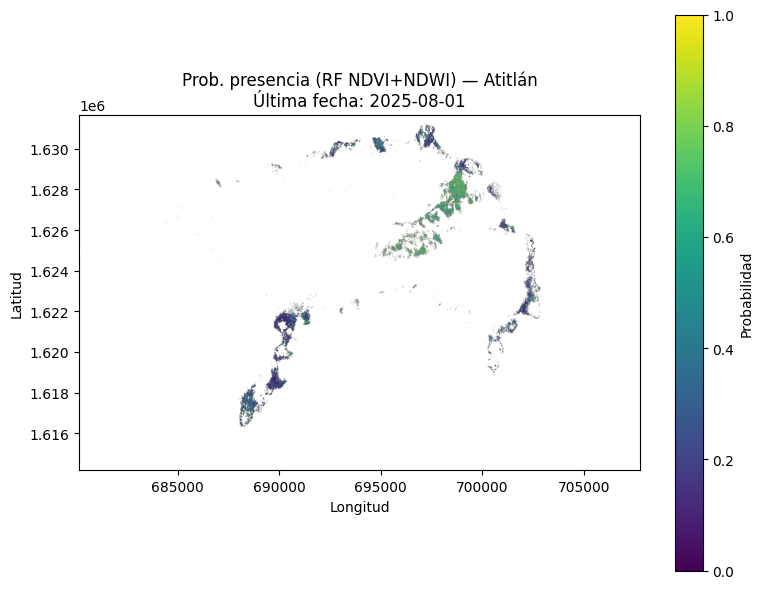

[ok] Atitlán: proj_presence_Atitlán.tif + PNG generado.


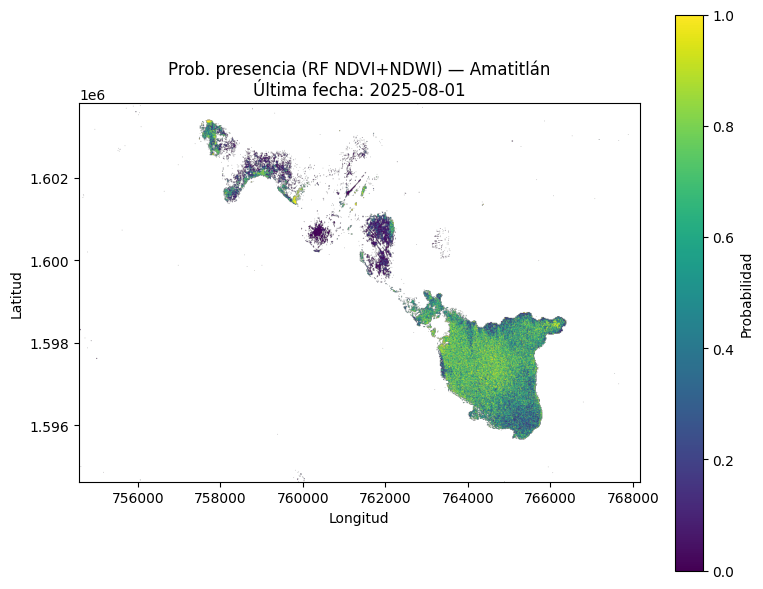

[ok] Amatitlán: proj_presence_Amatitlán.tif + PNG generado.


In [27]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

DERIV_DIR = Path("imgs")   # <--- AJUSTA si tus .tif están en otra carpeta
OUT_DIR   = Path("out"); OUT_DIR.mkdir(exist_ok=True)

SAMPLE_PER_IMAGE = 5000
RANDOM_STATE = 42
T_CHL_PRESENCE = 25.0     # mg/m3: umbral de presencia (ajustable)

# --- Utilidades ---
def scan_derivatives(dir_path=DERIV_DIR):
    """
    Busca tripletas (chl, ndvi, ndwi) por lago/fecha de la forma:
    <LAGO>_<YYYY-MM-DD>_(chl|ndvi|ndwi).tif
    """
    idx = {}
    pat = re.compile(r'(.+?)_(\d{4}-\d{2}-\d{2})_(chl|ndvi|ndwi)\.tif$', re.IGNORECASE)
    for f in dir_path.glob("*.tif"):
        m = pat.match(f.name)
        if not m:
            continue
        lake, d, typ = m.groups()
        key = (lake, d)
        if key not in idx:
            idx[key] = {"lake": lake, "date": d}
        idx[key][typ.lower()] = str(f)
    rows = [v for v in idx.values() if "chl" in v and "ndvi" in v and "ndwi" in v]
    rows.sort(key=lambda r: (r["lake"], r["date"]))
    return rows

def sample_from_derivatives(item, n=SAMPLE_PER_IMAGE, rng=np.random.default_rng(RANDOM_STATE)):
    """
    Muestra píxeles de NDVI/NDWI y etiqueta con CHL >= T_CHL_PRESENCE.
    No usa CHL como feature (evita fuga de información).
    """
    with rasterio.open(item["chl"]) as s1, rasterio.open(item["ndvi"]) as s2, rasterio.open(item["ndwi"]) as s3:
        CHL  = s1.read(1).astype("float32")
        NDVI = s2.read(1).astype("float32")
        NDWI = s3.read(1).astype("float32")
        profile = s1.profile

    mask = np.isfinite(CHL) & np.isfinite(NDVI) & np.isfinite(NDWI)
    ys, xs = np.where(mask)
    if ys.size == 0:
        return pd.DataFrame(), profile

    idx = rng.choice(ys.size, size=min(n, ys.size), replace=False)
    r, c = ys[idx], xs[idx]
    def pick(a): return a[r, c]

    X = pd.DataFrame({
        "NDVI": pick(NDVI),
        "NDWI": pick(NDWI),
    })
    y = (pick(CHL) >= T_CHL_PRESENCE).astype(int)
    X["label"] = y
    return X, profile

def last_item_for(rasters_idx, lake):
    items = [it for it in rasters_idx if it["lake"] == lake]
    if not items:
        return None
    return max(items, key=lambda z: z["date"])

def raster_extent(profile):
    """
    Extent geográfico para imshow (xmin, xmax, ymin, ymax)
    """
    transform = profile["transform"]
    height, width = profile["height"], profile["width"]
    xmin = transform[2]
    ymax = transform[5]
    px   = transform[0]
    py   = -transform[4] if transform[4] != 0 else transform[0]
    xmax = xmin + width * px
    ymin = ymax - height * py
    return xmin, xmax, ymin, ymax

def predict_presence_map_from_derivatives(clf, item):
    """
    Devuelve mapa de probabilidad usando SOLO NDVI y NDWI.
    """
    with rasterio.open(item["ndvi"]) as s2, rasterio.open(item["ndwi"]) as s3:
        NDVI = s2.read(1).astype("float32")
        NDWI = s3.read(1).astype("float32")
        profile = s2.profile

    mask = np.isfinite(NDVI) & np.isfinite(NDWI)
    H, W = NDVI.shape
    X = np.stack([NDVI, NDWI], axis=-1).reshape(-1, 2)

    proba = np.full(H*W, np.nan, dtype="float32")
    valid = mask.ravel()
    proba[valid] = clf.predict_proba(X[valid])[:, 1]
    proba_map = proba.reshape(H, W)
    return proba_map, profile

# --- 1) Indexar tus TIFs existentes (no descarga) ---
rasters_idx = scan_derivatives(DERIV_DIR)
print(f"Escenas encontradas: {len(rasters_idx)}")
if len(rasters_idx) == 0:
    print("No se encontraron tripletas chl/ndvi/ndwi en", DERIV_DIR)

# --- 2) Muestreo y entrenamiento (RF con NDVI+NDWI) ---
samples = []
for it in rasters_idx:
    dfS, _ = sample_from_derivatives(it)
    if not dfS.empty:
        dfS["lake"] = it["lake"]
        dfS["date"] = pd.to_datetime(it["date"])
        samples.append(dfS)

if samples:
    pix_df = pd.concat(samples, ignore_index=True)
    # Features sin CHL para evitar fuga (label depende de CHL)
    X = pix_df[["NDVI", "NDWI"]].values
    y = pix_df["label"].values

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    clf_lite = RandomForestClassifier(
        n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE
    )
    clf_lite.fit(Xtr, ytr)
    print(classification_report(yte, clf_lite.predict(Xte)))
    print("Matriz de confusión:\n", confusion_matrix(yte, clf_lite.predict(Xte)))
else:
    clf_lite = None
    print("No se pudieron crear muestras. Revisa que existan las tripletas por fecha.")

# --- 3) Proyección local (SIN DESCARGAR) para la última fecha de cada lago ---
if clf_lite is not None:
    for lake in ("Atitlán", "Amatitlán"):
        it = last_item_for(rasters_idx, lake)
        if it is None:
            print(f"[skip] {lake}: no hay escenas derivadas.")
            continue

        proba_map, profile = predict_presence_map_from_derivatives(clf_lite, it)

        # Guardar GeoTIFF georreferenciado
        proj_tif = OUT_DIR / f"proj_presence_{lake}.tif"
        prof = profile.copy(); prof.update(dtype="float32", count=1, nodata=np.nan)
        with rasterio.open(proj_tif, "w", **prof) as dst:
            dst.write(proba_map.astype("float32"), 1)

        # Visualizar con matplotlib y guardar PNG
        xmin, xmax, ymin, ymax = raster_extent(profile)
        plt.figure(figsize=(8, 6))
        plt.imshow(proba_map, origin="upper", extent=[xmin, xmax, ymin, ymax], vmin=0, vmax=1)
        plt.title(f"Prob. presencia (RF NDVI+NDWI) — {lake}\nÚltima fecha: {it['date']}")
        plt.xlabel("Longitud"); plt.ylabel("Latitud")
        plt.colorbar(label="Probabilidad")
        plt.tight_layout()
        plt.savefig(OUT_DIR / f"proj_presence_{lake}.png", dpi=180)
        plt.show()

        print(f"[ok] {lake}: {proj_tif.name} + PNG generado.")
else:
    print("No se generó proyección: no hay clasificador entrenado.")


## Resultados obtenidos

### 1) Lectura espacial de las proyecciones (01-ago-2025)

**Atitlán — Probabilidad de presencia (RF NDVI+NDWI)**

* **Patrón general:** valores bajos en el espejo central del lago con **manchas aisladas** de probabilidad media-alta (∼0.4–0.7) en **bordes y bahías protegidas**.
* **Interpretación:** es consistente con la **serie temporal baja-moderada** del lago y su **heterogeneidad litoral**. Las “islas” de probabilidad sugieren **zonas someras / orillas** donde la mezcla con vegetación ribereña o **floats** puede elevar NIR y, por tanto, el score del clasificador.
* **Cuidado metodológico:** esta proyección se entrenó con **NDVI+NDWI** (sin usar CHL como feature para evitar fuga). Aunque la máscara de agua reduce contaminación, algunos **falsos positivos** en ribera son esperables; un **buffer de orilla** de 1–2 píxeles o una máscara SCL más estricta puede mitigarlo.

**Amatitlán — Probabilidad de presencia (RF NDVI+NDWI)**

* **Patrón general:** **parche extenso y coherente** de probabilidad **alta** (0.6–0.9) en el **lóbulosur-sureste** y clústeres secundarios en el centro-norte.
* **Interpretación:** refleja un **sistema más eutrófico y variable**, en línea con los **picos altos de clorofila** observados en marzo y con niveles aún **moderados** a fin de julio / inicios de agosto. La **coherencia espacial** sugiere condiciones hidrológicas y de mezcla que sostienen el riesgo en sectores específicos.
* **Nota sobre la media vs. mapa:** aunque la **media diaria** de CHL para 2025-08-01 no es extrema, la **probabilidad** puede ser alta en **subregiones**: la proyección capta **heterogeneidad espacial** que la media (un valor global) oculta.

### 2) Coherencia con las series temporales y correlaciones

* **Con las series:** Atitlán se mantiene **estable y bajo**, por eso el mapa muestra **hotspots puntuales** más que un bloom extensivo. En Amatitlán, tras picos fuertes en marzo, los mapas de agosto aún muestran **regiones “en riesgo”** persistentes, coherentes con su **historial de alta variabilidad**.
* **Con las correlaciones:** en ambos lagos **NDVI** se correlaciona **positivamente** con CHL (moderado-alto), lo que respalda su poder predictivo. Para **NDWI**: señal **opuesta por lago** (negativa en Amatitlán al mirar rangos; positiva en Atitlán), lo que explica que el clasificador funcione **mejor** cuando se entrena **por lago** o con umbrales/normalizaciones específicas.

### 3) Fortalezas, limitaciones y cómo leer el mapa

* **Limitaciones:**

  * **Ribera**: riesgo de **falsos positivos** por mezcla con vegetación y macrófitas.
  * **Máscara**: aunque robusta, nubes finas/haze pueden introducir ruido.
  * **Umbral de presencia** (p. ej., 25 mg/m³) puede **ajustarse** según criterio sanitario/regulatorio.

* **Cómo leer el mapa:**

  * **>0.6**: alta probabilidad de presencia; priorizar **alerta/inspección**.
  * **0.3–0.6**: probabilidad intermedia; confirmar con imágenes cercanas en el tiempo o muestreo **rápido**.
  * **<0.3**: baja probabilidad; seguimiento rutinario.
